# Detecção de Infarto do miocárdio usando sinais ECG
O presente documento é a representação da rede neural do artigo: "Application of deep convolutional neural network for automated detection of myocardial infarction using ECG signals".
<br>
Retirado em: <a href= "https://www.sciencedirect.com/science/article/pii/S0020025517308009"> Application of deep convolutional neural network for automated detection of myocardial infarction using ECG signals </a>
## Artigo
O artigo utiliza redes neurais convolucionais para detectar automaticamente infarto do coração. Dois modelos diferentes foram utilizados, um com ruído e outro sem. Aqui reproduziremos a arquitetura com os ruídos.
## Database
Os dados foram retirados de: <a href= "https://www.physionet.org/content/ptbdb/1.0.0/"> PTB Diagnostic ECG Database </a>. Apesar de ter 9 classes, somente 2 foram utilizadas, as de pessoas saudáveis (52) e de infarto do miocárdio(148). Outro fator importante é que são utilizados 12 leads para classificação, entretanto somento o lead II é usado. Por último, a frequência de obtenção de sinais é de 2KHz.

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/cgalvao/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Carregar os dados

In [3]:
# Carregar a tabela csv
df = pd.read_csv("batimentos.csv")

cols = ['n']
for i in range(326):
    cols.append(str(i))
cols.append("Arritmia")
cols.append("Lead")
df.columns = cols
df.head()

,n,0,1,2,3,4,5,6,7,8,...,318,319,320,321,322,323,324,325,Arritmia,Lead
0,0,-0.071,-0.070,-0.070,-0.070,-0.07,-0.070,-0.070,-0.070,-0.070,...,-0.030,-0.027,-0.024,-0.025,-0.025,-0.025,-0.022,-0.019,164947007.0,2.0
1,1,-0.065,-0.065,-0.061,-0.060,-0.06,-0.060,-0.060,-0.060,-0.057,...,-0.005,-0.009,-0.024,-0.035,-0.031,-0.029,-0.030,-0.030,164947007.0,2.0
2,2,-0.070,-0.072,-0.069,-0.070,-0.07,-0.070,-0.070,-0.070,-0.070,...,-0.015,-0.015,-0.015,-0.010,-0.012,-0.001,0.008,-0.020,164947007.0,2.0
3,3,-0.070,-0.070,-0.070,-0.070,-0.07,-0.070,-0.070,-0.070,-0.070,...,0.035,0.035,0.035,0.035,0.032,0.029,0.030,0.030,164947007.0,2.0
4,4,-0.003,0.007,0.013,0.023,0.03,0.023,0.013,0.008,0.003,...,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,164947007.0,2.0


In [4]:
df['Arritmia'].unique()

array([1.64947007e+08, 4.26783006e+08])

In [5]:
classP=0
for el in df['Arritmia'].unique():
    df.loc[lambda df: df["Arritmia"] == el, "Arritmia"] = classP
    classP +=1
#df.loc[lambda df: df["Arritmia"] == 426783006.0, "Arritmia"] = 0
#df.loc[lambda df: df["Arritmia"] == 426627000.0, "Arritmia"] = 1
df['Arritmia'].unique()

array([0., 1.])

(array([4328.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3365.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

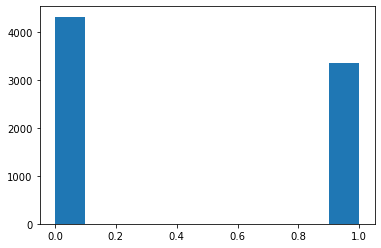

In [6]:
plt.hist(df.loc[:,"Arritmia"])

In [7]:
total_size = df.shape[0]

train_size = int(0.63 * total_size)
validation_size = int(0.27 * total_size)
test_size = total_size - (validation_size + train_size)

print(f"Train size: {train_size}, Validation size: {validation_size},\
 Test size: {test_size}")


Train size: 4846, Validation size: 2077, Test size: 770


In [8]:
df.head()

,n,0,1,2,3,4,5,6,7,8,...,318,319,320,321,322,323,324,325,Arritmia,Lead
0,0,-0.071,-0.070,-0.070,-0.070,-0.07,-0.070,-0.070,-0.070,-0.070,...,-0.030,-0.027,-0.024,-0.025,-0.025,-0.025,-0.022,-0.019,0.0,2.0
1,1,-0.065,-0.065,-0.061,-0.060,-0.06,-0.060,-0.060,-0.060,-0.057,...,-0.005,-0.009,-0.024,-0.035,-0.031,-0.029,-0.030,-0.030,0.0,2.0
2,2,-0.070,-0.072,-0.069,-0.070,-0.07,-0.070,-0.070,-0.070,-0.070,...,-0.015,-0.015,-0.015,-0.010,-0.012,-0.001,0.008,-0.020,0.0,2.0
3,3,-0.070,-0.070,-0.070,-0.070,-0.07,-0.070,-0.070,-0.070,-0.070,...,0.035,0.035,0.035,0.035,0.032,0.029,0.030,0.030,0.0,2.0
4,4,-0.003,0.007,0.013,0.023,0.03,0.023,0.013,0.008,0.003,...,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.0,2.0


In [9]:
header = df.columns

In [10]:
header

Index(['n', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '318', '319', '320', '321', '322', '323', '324', '325', 'Arritmia',
       'Lead'],
      dtype='object', length=329)

In [11]:
from torch.utils.data.dataset import Dataset

class Batimentos(Dataset):
  def __init__(self):
    xy = df
    self.x = torch.tensor(df[header[1:-2]].values, dtype= torch.float32).view(len(df),1,-1)
    self.y = torch.tensor((df[header[-2]].values), dtype= int)
    self.tamanho = xy.shape[0]
  
  def __len__(self):
    return self.tamanho
  
  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [12]:
dataset = Batimentos()

In [13]:
from torch.utils.data import DataLoader


batch_size = 32
train_data, validation, test_data = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle= True)
valid_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle= False)

<AxesSubplot:ylabel='Frequency'>

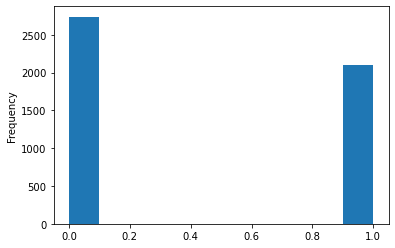

In [14]:
df.loc[train_loader.dataset.indices]['Arritmia'].plot(kind='hist')

In [15]:
print(train_loader.dataset.dataset.tamanho)
print(valid_loader.dataset.dataset.tamanho)
print(test_loader.dataset.dataset.tamanho)

7693
7693
7693


In [16]:
data, label = next(iter(train_loader))
print(data, label)
print(data.shape)

tensor([[[ 0.0000,  0.0000,  0.0030,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0100,  0.0060,  0.0020,  ...,  0.0540,  0.0490,  0.0450]],

        [[ 0.0920,  0.1030,  0.0880,  ...,  0.0330,  0.0000,  0.0080]],

        ...,

        [[-0.0230, -0.0290, -0.0360,  ..., -0.0700, -0.0660, -0.0650]],

        [[-0.0470, -0.0690, -0.0810,  ...,  0.0250,  0.0250,  0.0250]],

        [[-0.0630, -0.0680, -0.0630,  ..., -0.0780, -0.0780, -0.0830]]]) tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1])
torch.Size([32, 1, 326])


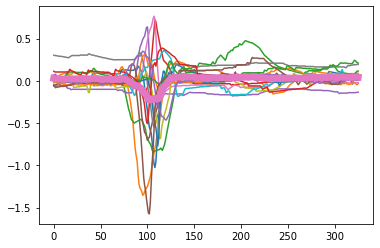

In [17]:
plt.plot(data[label==0,0,:].T);
plt.plot(data[label==0,0,:].T.mean(axis=1),linewidth=7);

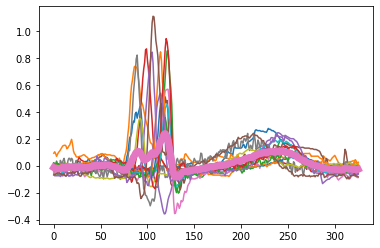

In [18]:
plt.plot(data[label==1,0,:].T);
plt.plot(data[label==1,0,:].T.mean(axis=1),linewidth=7);

In [19]:
len(train_loader.dataset)

4846

## Arquitetura

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Entrada de um vetor de 651 dados 
        self.conv1 = nn.Conv1d(1, 3, 51, padding=1)#102,51
        self.conv2 = nn.Conv1d(3, 10, 13, padding=1)#24,12
        self.conv3 = nn.Conv1d(10, 10, 5, padding=1)#11,6
        self.conv4 = nn.Conv1d(10, 10, 3, padding=1)#9,4
        self.pool = nn.MaxPool1d(2, stride= 2)
        self.fc1 = nn.Linear(150, 60)
        self.fc2 = nn.Linear(60, 10)
        self.fc3 = nn.Linear(10, 2)
        # Without Learnable Parameters
        self.batch1 = nn.BatchNorm1d(10, affine=False)

    def forward(self, x):
        # Muda o shape da convolução 1D
        #x = x.reshape(x.shape[0],1,-1)
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.batch1(self.pool(F.leaky_relu(self.conv2(x))))
        x = self.batch1(self.pool(F.leaky_relu(self.conv3(x))))
        x = self.batch1(self.pool(F.leaky_relu(self.conv4(x))))
        
        # flatten image input
        x = x.view(x.size(0), -1)


        # FC com leaky_relu
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        #x = F.softmax(self.fc3(x))
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv1d(1, 3, kernel_size=(51,), stride=(1,), padding=(1,))
  (conv2): Conv1d(3, 10, kernel_size=(13,), stride=(1,), padding=(1,))
  (conv3): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=150, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (batch1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)


In [21]:
if train_on_gpu:
    data = data.cuda()
tmp = model.pool(F.leaky_relu(model.conv1(data)))
print(tmp.shape)
tmp = model.pool(F.leaky_relu(model.conv2(tmp)))
print(tmp.shape)
tmp = model.pool(F.leaky_relu(model.conv3(tmp)))
print(tmp.shape)
tmp = model.pool(F.leaky_relu(model.conv4(tmp)))
print(tmp.shape)
tmp = tmp.view(tmp.size(0), -1)
print(tmp.shape)
tmp = F.leaky_relu(model.fc1(tmp))
print(tmp.shape)
tmp = F.leaky_relu(model.fc2(tmp))
print(tmp.shape)
tmp = model.fc3(tmp)
print(tmp.shape)
print(model(data))

torch.Size([32, 3, 139])
torch.Size([32, 10, 64])
torch.Size([32, 10, 31])
torch.Size([32, 10, 15])
torch.Size([32, 150])
torch.Size([32, 60])
torch.Size([32, 10])
torch.Size([32, 2])
tensor([[ 0.1525, -0.3432],
        [ 0.1007, -0.2340],
        [ 0.1665, -0.2770],
        [ 0.1916, -0.1691],
        [ 0.2164, -0.3311],
        [ 0.1108, -0.1690],
        [ 0.1737, -0.2104],
        [ 0.1287, -0.2096],
        [ 0.1387, -0.1747],
        [ 0.3390, -0.4473],
        [ 0.1114, -0.3003],
        [ 0.1172, -0.2756],
        [ 0.1023, -0.2873],
        [ 0.0972, -0.2989],
        [ 0.1919, -0.4161],
        [ 0.1480, -0.2653],
        [ 0.1768, -0.3064],
        [ 0.1271, -0.3173],
        [ 0.1511, -0.2385],
        [ 0.1063, -0.2519],
        [ 0.0576, -0.2269],
        [ 0.0651, -0.2680],
        [ 0.1515, -0.1800],
        [ 0.2330, -0.3653],
        [ 0.1778, -0.3146],
        [ 0.1104, -0.2741],
        [ 0.0781, -0.2544],
        [ 0.1655, -0.1361],
        [ 0.2329, -0.3805],
    

the regularization, momentum, and learning rate parameters are set to 0.2, 3 × 10 −4 , and 0.7 respectively.

In [22]:
import torch.optim as optim
regularization = 0.05
momentum = 0.99
lr = 0.001

criterion = nn.CrossEntropyLoss()

optmizer = optim.SGD(model.parameters(), lr= lr, momentum= momentum, weight_decay= regularization)

## Treino

In [23]:
def train_model(nEpochs = 10):
    train_loss_list =[]
    valid_loss_list = []

    valid_loss_min = np.Inf # Minimo valid loss

    for epoch in range(nEpochs):
        train_loss= 0
        validation_loss= 0

        model.train()
        for sample, target in train_loader:
            if train_on_gpu:
                sample, target = sample.cuda(), target.cuda()
        # Zerar o gradiente
            optmizer.zero_grad()
        # Gera saída do modelo
            outputs = model(sample)
        # Calcula o erro
            loss = criterion(outputs, target)
            train_loss+=loss.item()*sample.size(0)
        # Calcula os gradientes
            loss.backward()
        # Otimiza o modelo
            optmizer.step()
            
        model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            validation_loss += loss.item()*data.size(0)

        train_loss = train_loss/len(train_loader.dataset)
        train_loss_list.append(train_loss)
        
        validation_loss = validation_loss/len(valid_loader.dataset)
        valid_loss_list.append(validation_loss)
      
        if (not epoch%10):
            print(f"Época: {epoch} \nLoss Treino: {train_loss}")
            print(f"Loss validação: {validation_loss}")

        if validation_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min, validation_loss))
            torch.save(model.state_dict(), 'modelo_arritmia.pt')
            valid_loss_min = validation_loss

    return train_loss_list, valid_loss_list


In [24]:
trained_data, validated_data = train_model(300)

Época: 0 
Loss Treino: 0.42778842091511166
Loss validação: 0.42223474468011724
Validation loss decreased (inf --> 0.422235).  Saving model ...
Validation loss decreased (0.422235 --> 0.359714).  Saving model ...
Época: 10 
Loss Treino: 0.1611863844130485
Loss validação: 0.297345170979897
Validation loss decreased (0.359714 --> 0.297345).  Saving model ...
Época: 20 
Loss Treino: 0.15415354728009945
Loss validação: 0.4612203828692723
Época: 30 
Loss Treino: 0.1447719777178971
Loss validação: 0.35539124667156646
Época: 40 
Loss Treino: 0.14609474969510447
Loss validação: 1.1521882578106413
Época: 50 
Loss Treino: 0.16614676213865923
Loss validação: 0.5776115599078058
Época: 60 
Loss Treino: 0.15115144809771805
Loss validação: 0.7344728553013901
Época: 70 
Loss Treino: 0.1578714407002611
Loss validação: 1.0506829220225848
Época: 80 
Loss Treino: 0.1512342693204974
Loss validação: 0.8512259079219633
Época: 90 
Loss Treino: 0.15314174706083264
Loss validação: 0.528206871947131
Época: 100 
L

In [25]:
len(trained_data)

300

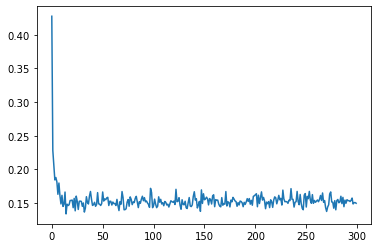

In [26]:
plt.plot(trained_data)

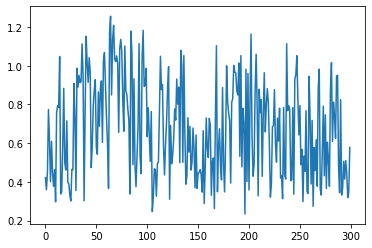

In [27]:
plt.plot(validated_data)

## Teste

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [29]:
# Matriz de confusão
def createCM(loader,model,nClasses):
  model.eval()

  accuracy = 0
  CM = np.zeros((nClasses,nClasses))
  y_pred = []
  y_true = []

  for sample1, target1 in loader:

    if train_on_gpu:
      sample1, target1 = sample1.cuda(), target1.cuda()
      model.cuda()

    prediction = model(sample1)
    outputsClass = torch.argmax(prediction, dim=1)

    if train_on_gpu:
      yt = np.array([t.cpu().numpy() for t in outputsClass])
      yp = np.array([t.cpu().numpy() for t in target1])

    else:
      yt = np.array([t.numpy() for t in outputsClass])
      yp = np.array([t.numpy() for t in target1])
      
    for x in range(len(yp)):
      y_pred.append(yp.item(x))
    for x in range(len(yt)):
      y_true.append(yt.item(x))

  CM = confusion_matrix(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  return CM, accuracy

In [30]:
matriz, acuracia = createCM(test_loader,model,2)

In [31]:
matriz

array([[419, 292],
       [ 11,  48]])

In [32]:
acuracia

0.6064935064935065

In [33]:
model_saved = Net()
model.load_state_dict(torch.load('modelo_arritmia.pt'))
model.eval()

Net(
  (conv1): Conv1d(1, 3, kernel_size=(51,), stride=(1,), padding=(1,))
  (conv2): Conv1d(3, 10, kernel_size=(13,), stride=(1,), padding=(1,))
  (conv3): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv4): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=150, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=2, bias=True)
  (batch1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
)

In [46]:
matriz, acuracia = createCM(test_loader,model,2)
matriz

array([[398,  27],
       [ 32, 313]])

In [48]:
acuracia*100

92.33766233766234